# Testing our workflow and a multivariate model (with almost 70 indicators)

In this notebook, we will test the functions we wrote earlier to go from a stock dataset, to a trained model.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dense
import keras.layers as layers
#from keras.preprocessing import 
import ta
import splitSequence as sq

In [68]:
data = pd.read_csv('../inputData/fb.us.txt')

In [19]:
datawInd = ta.add_all_ta_features(data, open = 'Open', high = 'High', low= 'Low', close='Close', volume='Volume', fillna=True)

In [20]:
datawInd.head()

,Date,Open,High,Low,Close,Volume,OpenInt,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
0,2012-05-18,42.05,45.00,38.00,38.23,580438450,0,-5.422954e+08,580438450,-0.934286,0.000000e+00,0.000000,0.000000,-3.148775e+08,1000.000000,0.0,38.230,38.23000,38.23000,0.000000,0.0,0.0,40.410000,40.410000,33.410000,0.0,0.0,38.23,38.23,1.0,1.0,0.000000,0.000000,0.000000,38.230000,38.230000,0.0,0.0,0.0,1.0,1.0,0.0,-53.065622,1.000000,0.000000,45.313827,-542.395873,-542.395873,0.000000,41.50,41.50,82.509827,80.723994,4.0,4.0,0.0,38.230000,-1.0,-1.000000,0.0,0.0,100.000000,50.0,0.000000,50.0,3.285714,3.285714,-96.714286,0.0,38.23,0.0,-54.239587,0.000000,0.000000
1,2012-05-21,36.53,36.66,33.00,34.03,169418988,0,-6.163583e+08,411019462,-0.821967,-7.115597e+08,-14.409365,-14.409365,-3.334400e+08,890.138635,0.0,36.130,40.33000,31.93000,8.400000,0.0,0.0,37.486667,37.486667,32.156667,0.0,0.0,34.03,38.23,0.0,1.0,-0.335043,-0.067009,-0.268034,37.583846,37.918889,0.0,0.0,0.0,1.0,1.0,0.0,-0.021457,1.922172,-66.666667,47.413827,-567.532380,-554.964126,-12.568254,39.00,39.00,82.509827,80.723994,4.0,8.0,-4.0,34.030000,-1.0,-1.000000,0.0,0.0,0.000000,50.0,-100.000000,50.0,8.583333,5.934524,-91.416667,0.0,34.03,0.0,-10.986137,-11.637806,-10.986137
2,2012-05-22,32.61,33.59,30.94,31.00,101876406,0,-7.136214e+08,309143056,-0.837846,-6.540063e+08,-6.672055,-10.540710,-2.768358e+07,810.881507,0.0,34.420,40.34898,28.49102,11.857959,0.0,0.0,35.605556,35.605556,31.168889,0.0,1.0,31.00,38.23,0.0,1.0,-0.835432,-0.220693,-0.614739,36.570947,37.406379,0.0,0.0,0.0,1.0,1.0,0.0,-0.071821,2.768421,-78.307123,49.123827,-588.000679,-565.976311,-22.024368,37.97,37.97,82.509827,80.723994,4.0,12.0,-8.0,45.000000,-1.0,45.000000,0.0,1.0,0.000000,50.0,-100.000000,50.0,0.426743,4.098597,-99.573257,0.0,31.00,0.0,-8.903908,-9.325528,-18.911849
3,2012-05-23,31.37,32.50,31.36,32.00,73678512,0,-7.045732e+08,382821568,-0.761361,-5.500513e+08,-0.518333,-7.199918,-6.694256e+06,837.038975,0.0,33.815,39.36089,28.26911,11.091781,0.0,0.0,34.692500,34.692500,31.080000,0.0,0.0,31.00,38.23,0.0,0.0,-1.138182,-0.404191,-0.733991,35.867724,37.005906,0.0,0.0,0.0,1.0,1.0,0.0,-0.134221,3.523470,-63.877958,49.728827,-595.242387,-573.292830,-21.949557,37.97,37.97,82.509827,80.723994,4.0,12.0,-8.0,44.718800,-1.0,44.718800,0.0,0.0,13.449899,50.0,-99.469379,50.0,7.539118,5.516398,-92.460882,0.0,32.00,0.0,3.225806,3.174870,-16.296103
4,2012-05-24,32.95,33.21,31.77,33.03,42560731,0,-6.726526e+08,425382299,-0.694908,-4.652100e+08,1.894704,-4.926262,3.746650e+06,863.981167,0.0,33.658,38.65799,28.65801,9.999981,0.0,0.0,34.288000,34.288000,31.110000,0.0,0.0,31.00,38.23,0.0,0.0,-1.280243,-0.579401,-0.700842,35.431151,36.711395,0.0,0.0,0.0,1.0,1.0,0.0,-0.196632,4.222638,-42.152980,49.885827,-597.121640,-578.058592,-19.063048,37.97,37.97,82.509827,80.723994,4.0,12.0,-8.0,44.443224,-1.0,44.443224,0.0,0.0,24.686023,50.0,-98.483221,50.0,14.864865,7.610242,-85.135135,0.0,33.03,0.0,3.218750,3.168034,-13.601883


In [67]:
train, test = sq.timeseriesSplitTestTrain(datawInd)

In [22]:
n_steps = 50
Xtrain = sq.shapeXinputforColumns(np.array(train), n_steps=n_steps, col_indexes=list(range(1, len(datawInd.columns))))
Xtest = sq.shapeXinputforColumns(np.array(test), n_steps=n_steps, col_indexes=list(range(1, len(datawInd.columns))))
ytrain = sq.splitSeqGety(np.array(train)[:,1],n_steps)
ytest = sq.splitSeqGety(np.array(test)[:,1],n_steps)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(1055, 50, 73) (226, 50, 73) (1055,) (226,)


In [23]:
input_shape = Xtrain.shape[1:]
input_shape

(50, 73)

In [24]:
model = Sequential()
model.add(LSTM(128, input_shape=(input_shape), return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
model.add(Dense(1, activation="linear", kernel_initializer="uniform"))
model.compile(optimizer='adam',loss='mean_squared_error')

In [25]:
#model.compile(optimizer='adam', loss='mse')

In [54]:
model.fit(x= Xtrain, y=ytrain, epochs=30, batch_size=32, validation_data=(Xtest, ytest), use_multiprocessing=True)

Train on 1055 samples, validate on 226 samples
Epoch 1/30
1055/1055 [==============================] - 3s 2ms/step - loss: 14.6071 - val_loss: 1365.8575
Epoch 2/30
1055/1055 [==============================] - 2s 2ms/step - loss: 13.9997 - val_loss: 1338.4511
Epoch 3/30
1055/1055 [==============================] - 2s 2ms/step - loss: 15.7026 - val_loss: 1313.9821
Epoch 4/30
1055/1055 [==============================] - 2s 2ms/step - loss: 14.4294 - val_loss: 1314.7730
Epoch 5/30
1055/1055 [==============================] - 2s 2ms/step - loss: 15.1629 - val_loss: 1278.0542
Epoch 6/30
1055/1055 [==============================] - 2s 2ms/step - loss: 14.0866 - val_loss: 1274.7799
Epoch 7/30
1055/1055 [==============================] - 2s 2ms/step - loss: 14.6100 - val_loss: 1353.5682
Epoch 8/30
1055/1055 [==============================] - 2s 2ms/step - loss: 15.0279 - val_loss: 1231.1562
Epoch 9/30
1055/1055 [==============================] - 2s 2ms/step - loss: 14.1471 - val_loss: 1223.2298

In [27]:
y_pred = model.predict(Xtest, batch_size=32)
y_pred[:,0].shape

(226,)

In [52]:
y_pred

array([[118.87797 ],
       [118.87718 ],
       [118.87645 ],
       [118.87572 ],
       [118.87503 ],
       [118.87436 ],
       [118.87369 ],
       [118.87302 ],
       [118.87232 ],
       [118.87158 ],
       [118.87079 ],
       [118.869934],
       [118.86906 ],
       [118.86813 ],
       [118.86716 ],
       [118.86609 ],
       [118.864914],
       [118.863525],
       [118.86154 ],
       [118.86162 ],
       [118.8622  ],
       [118.86492 ],
       [118.86354 ],
       [118.86155 ],
       [118.86165 ],
       [118.86238 ],
       [118.86756 ],
       [118.89576 ],
       [118.951904],
       [118.951904],
       [118.95191 ],
       [118.95191 ],
       [118.951904],
       [118.951904],
       [118.951904],
       [118.951904],
       [118.951904],
       [118.951904],
       [118.951904],
       [118.951904],
       [118.951904],
       [118.951904],
       [118.951904],
       [118.951904],
       [118.951904],
       [118.951904],
       [118.951904],
       [118.9

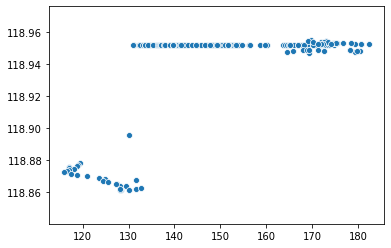

In [29]:
sns.scatterplot(x=ytest, y=y_pred[:,0])

In [49]:
stacked = np.stack((ytest, y_pred[:,0]))
comparison = pd.DataFrame({'ytest': ytest, 'ypred': y_pred[:,0]})
#comparison.reset_index(inplace=True)
display(comparison.head())

,ytest,ypred
0,119.50,118.877968
1,118.92,118.877182
2,118.86,118.876450
3,117.00,118.875717
4,116.96,118.875031


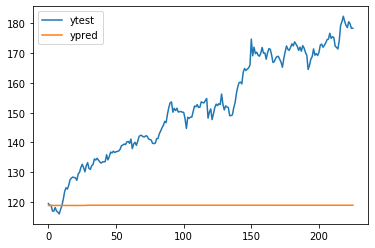

In [50]:
comparison.plot()

Model seems to overfit substantially, which explains the very bad performance.

In [56]:
# define model
model = Sequential()
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [57]:
model.fit(x= Xtrain, y=ytrain, epochs=30, batch_size=32, validation_data=(Xtest, ytest), use_multiprocessing=True)

Train on 1055 samples, validate on 226 samples
Epoch 1/30
1055/1055 [==============================] - 1s 502us/step - loss: 27072916355760332.0000 - val_loss: 4832575882886298.0000
Epoch 2/30
1055/1055 [==============================] - 0s 307us/step - loss: 379394560107994.6250 - val_loss: 170641729419862.0938
Epoch 3/30
1055/1055 [==============================] - 0s 332us/step - loss: 30870230129562.0859 - val_loss: 116509247713461.2344
Epoch 4/30
1055/1055 [==============================] - 0s 418us/step - loss: 12637721621128.3711 - val_loss: 123071065060234.1875
Epoch 5/30
1055/1055 [==============================] - 0s 395us/step - loss: 11265864981867.9824 - val_loss: 109106291057437.4531
Epoch 6/30
1055/1055 [==============================] - 0s 313us/step - loss: 10366686487917.9219 - val_loss: 117146827353568.2812
Epoch 7/30
1055/1055 [==============================] - 0s 295us/step - loss: 10220192093235.4414 - val_loss: 73838921969700.2656
Epoch 8/30
1055/1055 [==========

It seems like adding so many indicators has degraded the quality of the models that previously worked better. We can return to just using the core variables, and see how well the models work.

In [60]:
display(train.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt',
       'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_nvi', 'volatility_atr',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch',
       'volatility_dchi', 'volatility_dcli', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_a',
       'trend_ichimoku_b', 'trend_visual_ichimoku_a',
       'trend_visual_ichimoku_b', 'trend_aroon_up

In [70]:
train, test = sq.timeseriesSplitTestTrain(data)
train

,Date,Open,High,Low,Close,Volume,OpenInt
0,2012-05-18,42.05,45.000,38.00,38.23,580438450,0
1,2012-05-21,36.53,36.660,33.00,34.03,169418988,0
2,2012-05-22,32.61,33.590,30.94,31.00,101876406,0
3,2012-05-23,31.37,32.500,31.36,32.00,73678512,0
4,2012-05-24,32.95,33.210,31.77,33.03,42560731,0
...,...,...,...,...,...,...,...
1100,2016-10-03,128.38,129.090,127.80,128.77,12679294,0
1101,2016-10-04,129.17,129.277,127.55,128.19,13054820,0
1102,2016-10-05,128.25,128.800,127.83,128.47,11988090,0
1103,2016-10-06,128.43,129.060,128.08,128.74,11261317,0


In [71]:
# Prepare the data
n_steps = 50
col_indexes = [1,2,3,4,5]
y_index = 1
Xtrain = sq.shapeXinputforColumns(np.array(train), n_steps=n_steps, col_indexes=col_indexes)
Xtest = sq.shapeXinputforColumns(np.array(test), n_steps=n_steps, col_indexes=col_indexes)
ytrain = sq.splitSeqGety(np.array(train)[:,1],n_steps)
ytest = sq.splitSeqGety(np.array(test)[:,1],n_steps)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(1055, 50, 5) (226, 50, 5) (1055,) (226,)


In [75]:
np.array(train)[:,1]

array([42.05, 36.53, 32.61, ..., 128.25, 128.43, 129.04], dtype=object)

In [76]:
ytrain

array([ 23.37,  21.5 ,  20.77, ..., 128.25, 128.43, 129.04])

In [72]:
# define input shape
input_shape = Xtrain.shape[1:]

# define model
model = Sequential()
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(x= Xtrain, y=ytrain, epochs=200, batch_size=32, validation_data=(Xtest, ytest), use_multiprocessing=True)

ss: 50238344726.8095 - val_loss: 8777617729.6991
Epoch 42/200
1055/1055 [==============================] - 0s 129us/step - loss: 35172006456.7810 - val_loss: 7107733558.3717
Epoch 43/200
1055/1055 [==============================] - 0s 129us/step - loss: 44188106643.2910 - val_loss: 11120947363.1150
Epoch 44/200
1055/1055 [==============================] - 0s 130us/step - loss: 33869617742.1346 - val_loss: 6669128858.0531
Epoch 45/200
1055/1055 [==============================] - 0s 127us/step - loss: 36080539488.8190 - val_loss: 7740135849.9115
Epoch 46/200
1055/1055 [==============================] - 0s 130us/step - loss: 35085434821.7630 - val_loss: 6977174740.9558
Epoch 47/200
1055/1055 [==============================] - 0s 132us/step - loss: 58896179580.4815 - val_loss: 14157684572.8850
Epoch 48/200
1055/1055 [==============================] - 0s 131us/step - loss: 45900281834.6464 - val_loss: 7283011873.9823
Epoch 49/200
1055/1055 [==============================] - 0s 130us/step - 

# Testing with scaling of data as well



In [78]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [89]:
data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2012-05-18,42.05,45.00,38.00,38.23,580438450,0
1,2012-05-21,36.53,36.66,33.00,34.03,169418988,0
2,2012-05-22,32.61,33.59,30.94,31.00,101876406,0
3,2012-05-23,31.37,32.50,31.36,32.00,73678512,0
4,2012-05-24,32.95,33.21,31.77,33.03,42560731,0


In [90]:
length = 50
gen = TimeseriesGenerator(data = np.array(data)[:,1:6], targets=np.array(data)[:,1], length=length, batch_size=32)

In [92]:
model.fit_generator(gen, epochs=200)

Epoch 1/200
42/42 [==============================] - 0s 4ms/step - loss: 10294614923.5276
Epoch 2/200
42/42 [==============================] - 0s 4ms/step - loss: 1047218174.1352
Epoch 3/200
42/42 [==============================] - 0s 5ms/step - loss: 304681699.7682
Epoch 4/200
42/42 [==============================] - 0s 5ms/step - loss: 189454332.0711
Epoch 5/200
42/42 [==============================] - 0s 5ms/step - loss: 120301691.4354
Epoch 6/200
42/42 [==============================] - 0s 5ms/step - loss: 52237874.0292
Epoch 7/200
42/42 [==============================] - 0s 5ms/step - loss: 27891650.1142
Epoch 8/200
42/42 [==============================] - 0s 5ms/step - loss: 18582498.1015
Epoch 9/200
42/42 [==============================] - 0s 5ms/step - loss: 13098814.0283
Epoch 10/200
42/42 [==============================] - 0s 4ms/step - loss: 9585742.4736
Epoch 11/200
42/42 [==============================] - 0s 6ms/step - loss: 7330264.1494
Epoch 12/200
42/42 [===============

In [96]:
import math
math.sqrt(13068.6651)
# Not too bad, let's try to separate the frames into training and testing frames

114.31826232059338

In [97]:
split_index = math.ceil(len(data) * 0.8)

In [98]:
genTrain = TimeseriesGenerator(data = np.array(data)[:,1:6], targets=np.array(data)[:,1], length=length, batch_size=32, end_index=split_index)
genTest = TimeseriesGenerator(data = np.array(data)[:,1:6], targets=np.array(data)[:,1], length=length, batch_size=32, start_index=split_index + 1)

In [99]:
model.fit_generator(gen, epochs=200, validation_data=genTest)

/42 [==============================] - 0s 5ms/step - loss: 10634.7701 - val_loss: 31806.0312
Epoch 16/200
42/42 [==============================] - 0s 5ms/step - loss: 10558.8677 - val_loss: 31805.6543
Epoch 17/200
42/42 [==============================] - 0s 6ms/step - loss: 10443.9338 - val_loss: 31805.2578
Epoch 18/200
42/42 [==============================] - 0s 6ms/step - loss: 10357.2531 - val_loss: 31804.8828
Epoch 19/200
42/42 [==============================] - 0s 6ms/step - loss: 10277.1461 - val_loss: 31804.4688
Epoch 20/200
42/42 [==============================] - 0s 5ms/step - loss: 10202.5705 - val_loss: 31804.0488
Epoch 21/200
42/42 [==============================] - 0s 4ms/step - loss: 10134.2191 - val_loss: 31803.6465
Epoch 22/200
42/42 [==============================] - 0s 10ms/step - loss: 10067.4791 - val_loss: 31803.2285
Epoch 23/200
42/42 [==============================] - 0s 6ms/step - loss: 10007.5779 - val_loss: 31802.7812
Epoch 24/200
42/42 [======================